# An Autoencoder for MNIST

> In this tutorial, we are going to build an AutoEncoder for the MNIST dataset, that learns to represent 28x28 images using only 10 numbers.
> 
> Author: Bjarne C. Hiller

## What is an Autoencoder?

An Autoencoder is a neural network, that consists of two main parts (can you guess how the parts are named?):

1. An Encoder
2. A Decoder

The objective of an Autoencoder is to learn, how the high-dimensional input can be represented in a lower dimensionial space.
The Encoder learns how to *encode* the observed input as a smaller *latent representation*.
The Decoder learns to *decode* the latent representation back into the original feature space.
Autoencoders are trained in a self-supervised manner (hence, **Auto**encoders):
The input is fed into the encoder, the output of the encoder is given to the decoder, which then tries to reconstruct the original input.
Compared to normal *supervised* learning, there are no explicit labels.

That already sounds quite technical, so let's illustrate how an Autoencoder works using a simple example:
Imagine you went to an art exhibition on [Salvador Dalí](https://en.wikipedia.org/wiki/Salvador_Dal%C3%AD).
Afterwards, your friend asks you to describe one of the images using only 3 words.
In this example, you are the *encoder*, which compresses the complex *input* - the abstract image - into a *simpler latent representation* - just 3 words.
You describe the image to your friend as: `MELTING CLOCKS [on the] BEACH`.
Your friend tries now to imagine, how this painting probably looked like given your description and tries to paint it theirself.
In this example, your friend becomes the *decoder*, that attempts to reconstruct the original painting ([The persistence of Memory](https://en.wikipedia.org/wiki/The_Persistence_of_Memory)) from the latent representation.
Afterwards, you can compare how accurate their version is - and probably have a good laugh.

![MELTING CLOCKS [on the] BEACH](figures/dali_the_persistence_of_memory.jpg)

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm, trange
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms.v2 import ToTensor, Normalize, Compose, ToImage, ToDtype

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load MNIST Data

We will train our Autoencoder on the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.
The dataset contains 28x28 greyscale images of handwritten numbers labelled 0 to 9.
Our Autoencoder will compress the information from 784 pixels into only 10 numbers.

In [2]:
# load the dataset with help from torchvision

transform = Compose([
    # formerly used ToTensor, which is decaprecated now
    # transforms images to torchvision.tv_tensors_Image
    ToImage(),
    # with scale=True, scales pixel intensities from [0,255] to [0.0,1.0]
    ToDtype(torch.float32, scale=True),
    # could normalize the pixel intensity value to overall mean and std of train set
    # Normalize([0.1307], [0.3081]),
])

train_ds = MNIST("data/", train=True, download=True, transform=transform)
test_ds = MNIST("data/", train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 9.51MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 272kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.2MB/s]


To access images, use `train_ds[i][0]` to get the transformed and scaled version.
Don't use `train_ds.data[i]`, unless you want the raw image.

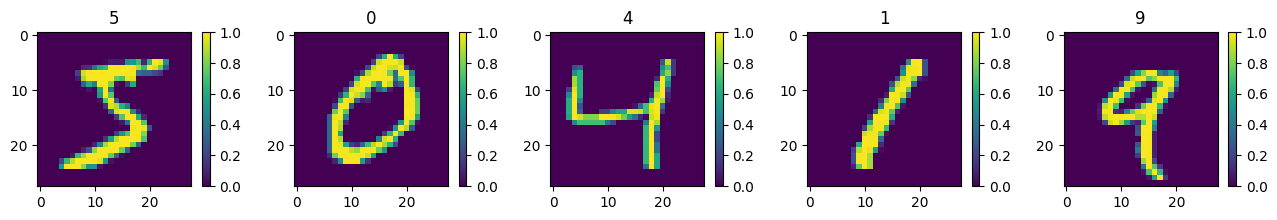

In [3]:
# plot the first 5 images

plt.figure(figsize=(16,2))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_ds[i][0].numpy().squeeze())
    plt.title(train_ds[i][1])
    plt.colorbar()

## t-SNE embedding

To visualize the dataset, we can also use t-SNE to embed them in a 2-dimensional space.

In [4]:
# only use a subset for t-sne to speed things up
n_tsne = 1_000

labels = train_ds.targets[:n_tsne].numpy()
X = torch.stack([train_ds[i][0] for i in range(n_tsne)]).flatten(start_dim=1).numpy()

X.shape

(1000, 784)

In [5]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [6]:
tsne_df = pd.DataFrame({
    "tsne_1": X_tsne[:, 0],
    "tsne_2": X_tsne[:, 1],
    "label": labels.astype(str)
})

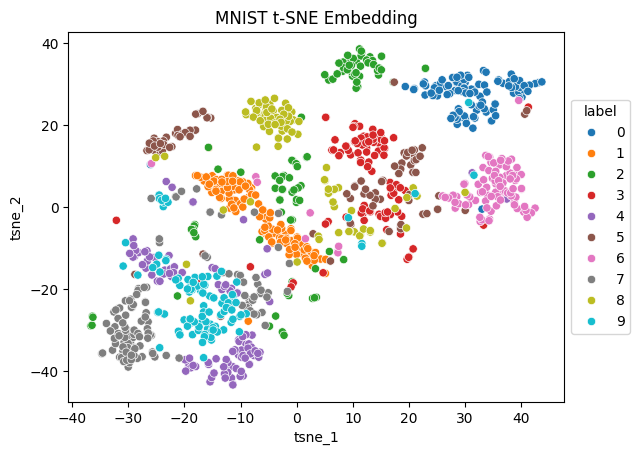

In [7]:
ax = sns.scatterplot(tsne_df.sort_values("label"), x="tsne_1", y="tsne_2", hue="label")
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
plt.title("MNIST t-SNE Embedding");

Numbers from the same class seem to be close together in the low-dimensional t-SNE space - except for 2s, that are all over the place and surprisingly close to all other numbers. Also, note how there are two clusters of 5s: One close to 8s and 2s, and one leaning more towards 3s.

## Let's build a sparse convolutional AutoEncoder!

In [23]:
class Encoder(nn.Module):
    def __init__(self, n_latent=10, activation="relu", *args, **kwargs):
        """Our Encoder: compresses the input image to a low-dimensional representation."""
        super().__init__(*args, **kwargs)
        # how many dimensions our latent space has
        self.n_latent = n_latent
        
        # make different activations available for playing around
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "softmax":
            self.activation = nn.Softmax(dim=1)
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        else:
            self.activation = activation

        self.conv = nn.Sequential(
            # shape: (N,1,28,28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), padding=2),
            # shape: (N,8,28,28)
            nn.MaxPool2d((2,2)),
            # shape: (N,8,14,14)
            # batch norms will help to stabilize and speed up training
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # shape: (N,8,14,14)
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(5,5), padding=2),
            # shape: (N,8,14,14)
            nn.MaxPool2d((2,2)),
            nn.BatchNorm2d(8),
            # shape: (N,8,7,7)
            nn.ReLU(),
            # shape: (N,8,7,7)
            # nn.Flatten(),
        )
        
        self.linear = nn.Sequential(
            # shape: (N,392)
            nn.Linear(392, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, self.n_latent),
            # apply a softmax function
            # basically turning this into a one hot encoded vector
            self.activation
        )
 
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = x.flatten(start_dim=1)
        x = self.linear(x)
        return x

In [24]:
class Decoder(nn.Module):
    def __init__(self, n_latent=10, *args, **kwargs):
        """Our Decoder: acts inversely to the encoder and decompresses the latent representation back into an image."""
        super().__init__(*args, **kwargs)
        self.n_latent = n_latent
        self.linear = nn.Sequential(
            nn.Linear(self.n_latent, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            # nn.Unflatten(dim=1, unflattened_size=(8,8,7))
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(8, 8, (5,5), padding=2, stride=2, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # output_padding does not actually add 0s around the output, just increases the size
            nn.ConvTranspose2d(8, 1, (5,5), padding=2, stride=2, output_padding=1),
            # apply sigmoid to map to [0,1]
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor):
        # input shape (N, 10)
        x = self.linear(x)
        # reshape x to the right dimensions
        x = x.unflatten(1, (8,7,7))
        # transposed convolution
        x = self.deconv(x)
        return x

In [25]:
class AutoEncoder(nn.Module):
    def __init__(self, n_latent=10, encoder_kwargs=None, decoder_kwargs=None):
        super().__init__()
        self.n_latent = n_latent
        encoder_kwargs = dict() if encoder_kwargs is None else encoder_kwargs
        decoder_kwargs = dict() if decoder_kwargs is None else decoder_kwargs
        self.encoder = Encoder(self.n_latent, **encoder_kwargs)
        self.decoder = Decoder(self.n_latent, **decoder_kwargs)
    
    def forward(self, x):
        """Returns reconstruction and latent representation."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

## Training Time!

In [26]:
# wrap our train and test datasets in a DataLoader
# will automatically group samples in batches for training
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

In [28]:
def train(model, train_dl, n_epochs, lambda_l1=0, lambda_ent=0, log_interval=100, device="cpu"):
    """Train an autoencoder to reproduce the input."""
    model.to(device)
    model.train()
    criterion = nn.MSELoss()
    loss_log = []
    optimizer = Adam(model.parameters(), lr=1e-4)
    l1 = nn.L1Loss()

    step = 0
    for epoch in trange(n_epochs):
        for x, _ in train_dl:
            x = x.to(device)
            x_hat, z = model(x)
            loss = criterion(x_hat, x)
            # add l1 loss to enforce sparsity in latent representation
            loss += lambda_l1 * l1(z, torch.zeros_like(z))
            # add entropy loss term to encourage latent representations with small entropy
            # i.e., one hot like encodings
            entropy = -1 * torch.sum(z * torch.log(z), dim=1).mean()
            loss += lambda_ent * entropy

            if step % log_interval == 0:
                loss_log.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step += 1
    
    return loss_log

In [29]:
# parameters to play around with :)

# hyper-parameters to play around with
EPOCHS = 5

# number of latent dimensions
N_LATENT = 10

# latent activation function
ACTIVATION = "sigmoid"

# regularization strengths to encourage sparseness

## l1 regularization should be used with relu/sigmoid activation
LAMBDA_L1 = 1e-1

## entropy regularization should be used with softmax activation
LAMDA_ENT = 0

In [30]:
encoder_kwargs = {"activation": ACTIVATION}
decoder_kwargs = {}

model = AutoEncoder(n_latent=N_LATENT, encoder_kwargs=encoder_kwargs, decoder_kwargs=decoder_kwargs)

loss_log = train(model, train_dl, EPOCHS, lambda_ent=LAMDA_ENT, lambda_l1=LAMBDA_L1, device=device)

100%|██████████| 5/5 [00:47<00:00,  9.46s/it]


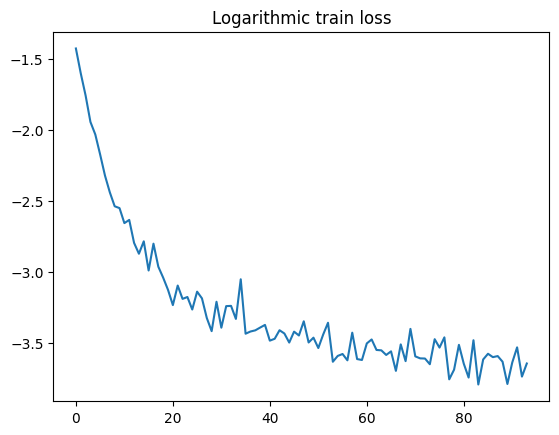

In [31]:
def plot_loss(loss_log):
    plt.plot(np.log(loss_log))
    plt.title("Logarithmic train loss");

plot_loss(loss_log)

## Can our AutoEncoder reconstruct the input images?

In [32]:
# switch model from train to test (eval) mode
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (activation): Sigmoid()
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
    )
    (linear): Sequential(
      (0): Linear(in_features=392, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=10, bias=True)
      (4): Sigmoid()
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0):

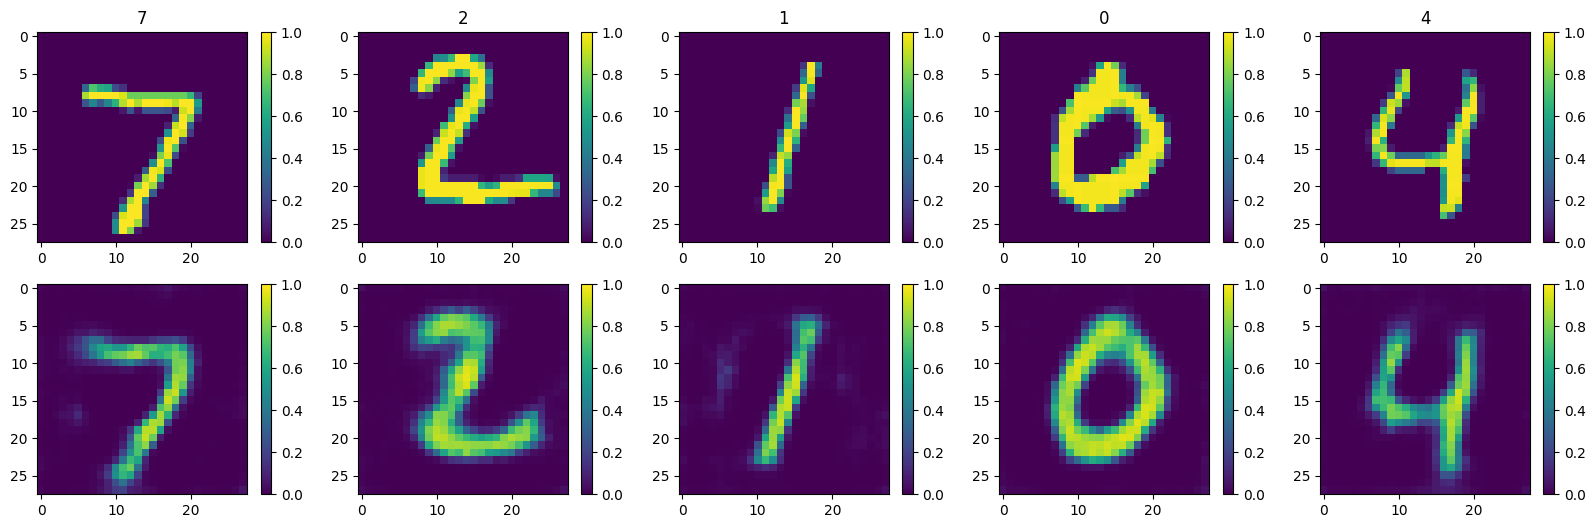

In [36]:
n_plot = 5

x = torch.stack([test_ds[i][0] for i in range(n_plot)])
y = [test_ds[i][1] for i in range(n_plot)]

def plot_reco(model, x, y):

    model.eval()
    with torch.no_grad():
        x_hat, _ = model(x.to(device))
        x_hat = x_hat.cpu()

    plt.figure(figsize=(20,6))

    n = len(y)
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(x[i].numpy().squeeze(), vmin=0, vmax=1)
        plt.title(y[i])
        plt.colorbar()

        plt.subplot(2, n, i+1+5)
        plt.imshow(x_hat[i].numpy().squeeze(), vmin=0, vmax=1)
        plt.colorbar()

    plt.show()

plot_reco(model, x, y)

## Latent Representations

- softmax alone is not enough to enfource discrete, one-hot like latent representations
    - could implement softmax with temperature
    - or extent loss function with penalty term for l1 norm or entropy of latent representation
    - or cheat gradients with a straight through operator
- playing around with the temperature actually influences if latent representations are sparse or not!

In [37]:
# get latent representation for test set

model.eval()

# only use subset of test set to speed things up
n_test = 1_000

x_test = torch.stack([test_ds[i][0] for i in range(n_test)])
y_test = torch.tensor([test_ds[i][1] for i in range(n_test)])

with torch.no_grad():
    x_hat, z_test = model(x_test.to(device))
    x_hat = x_hat.cpu()
    z_test = z_test.cpu()

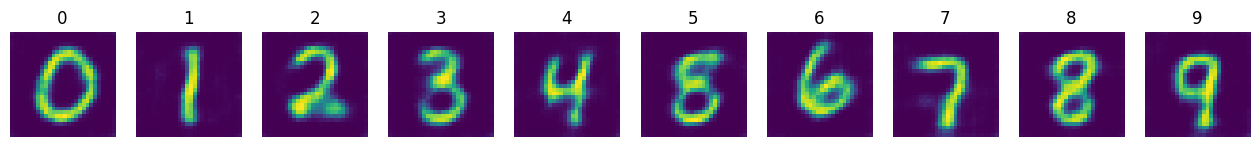

In [39]:
# plot reconstruction for mean latent representation

def plot_mean_latent_reco(model, z, y):
    plt.figure(figsize=(16, 4))
    for i in range(10):
        mean_z = z[y == i].mean(dim=0)

        with torch.no_grad():
            mean_x_hat = model.decoder(mean_z.unsqueeze(0).to(device)).cpu()
        
        plt.subplot(1, 10, i+1)
        plt.axis(False)
        plt.title(i)
        plt.imshow(mean_x_hat.squeeze())

plot_mean_latent_reco(model, z_test, y_test)

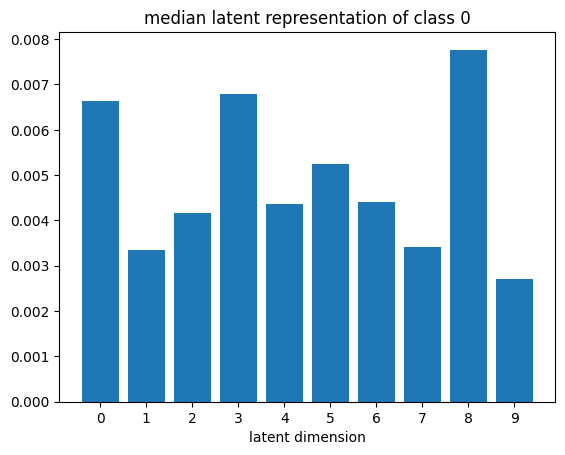

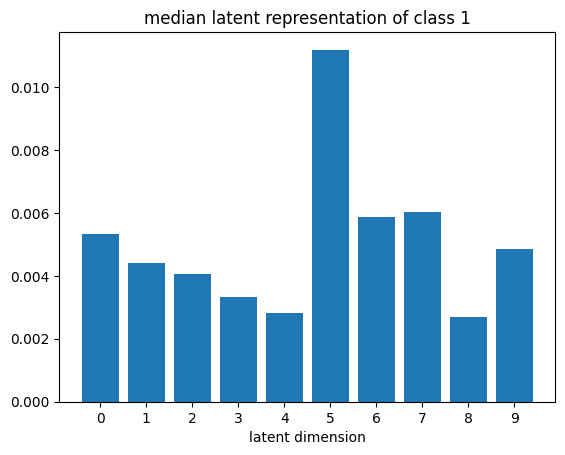

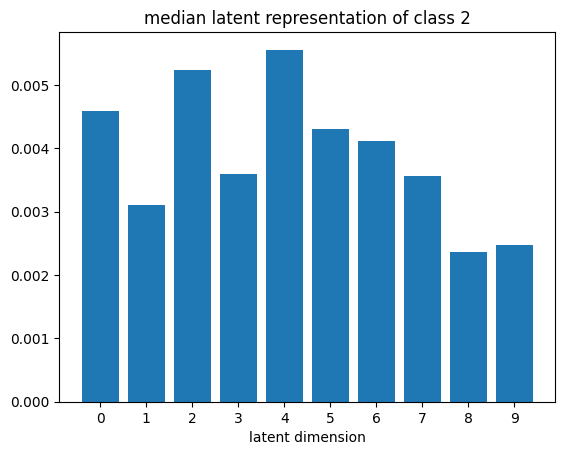

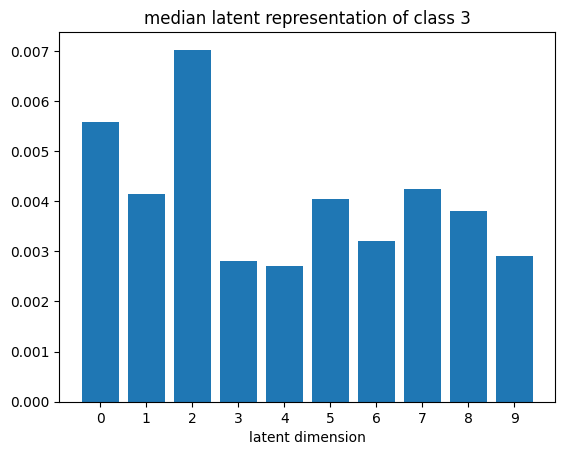

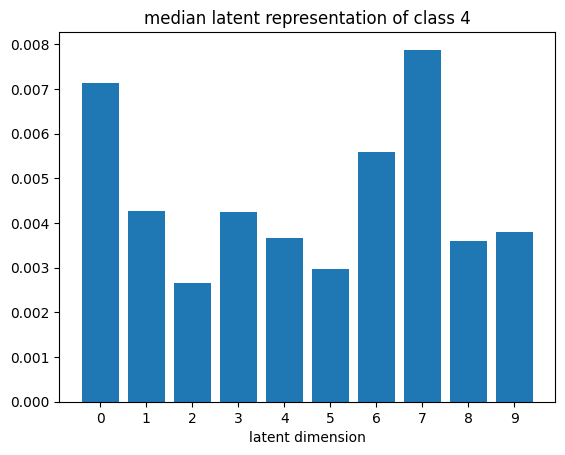

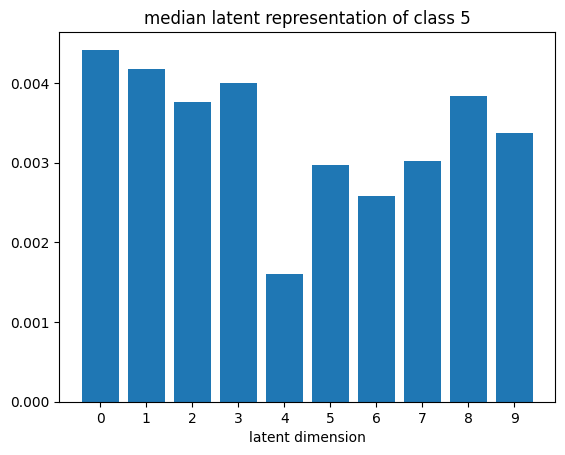

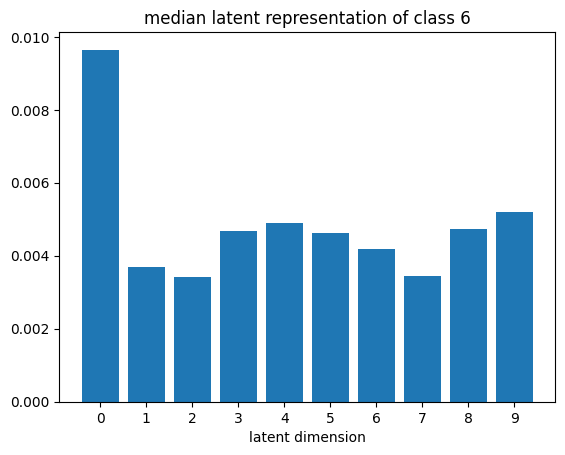

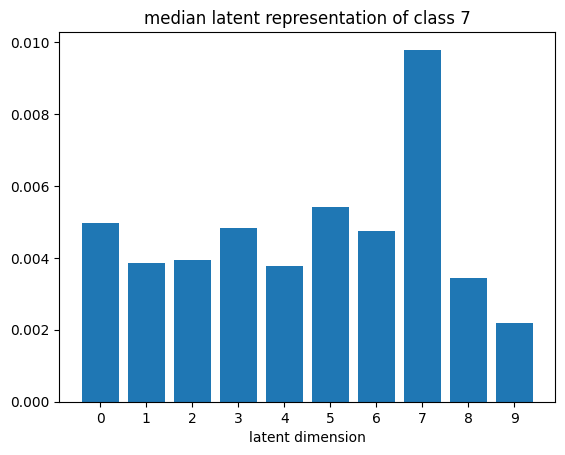

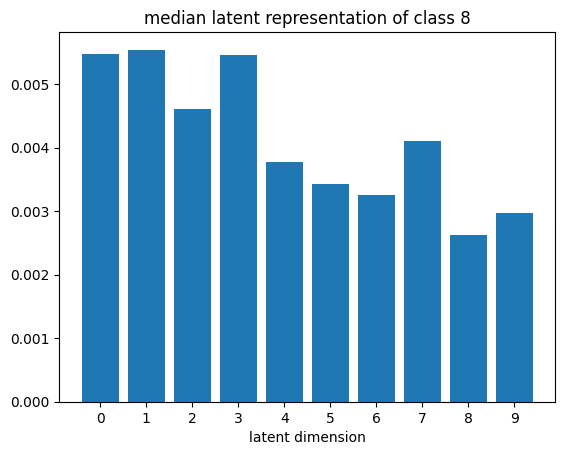

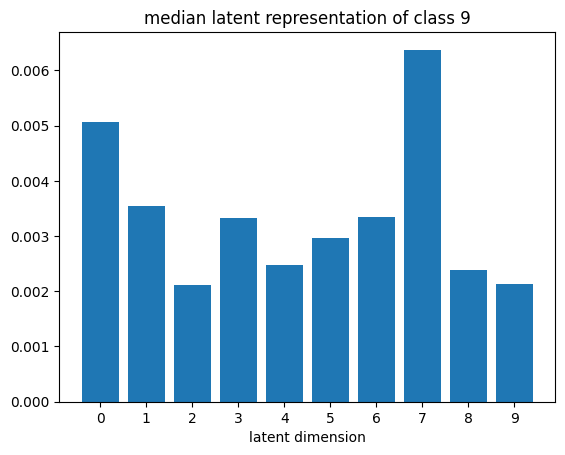

In [40]:
# visualize median latent representations

def plot_latent_median(z, y):
    for i in range(10):
        #m,_ = z_test[y_test == i].median(dim=0)
        m = z[y == i].mean(dim=0)
        #m = z_test[y_test == i][0]
        #m = z_test[y_test == i].std(dim=0)
        plt.bar(np.arange(N_LATENT).astype(str), m.numpy())
        plt.title(f"median latent representation of class {i}")
        plt.xlabel("latent dimension")
        plt.show()

plot_latent_median(z_test, y_test)

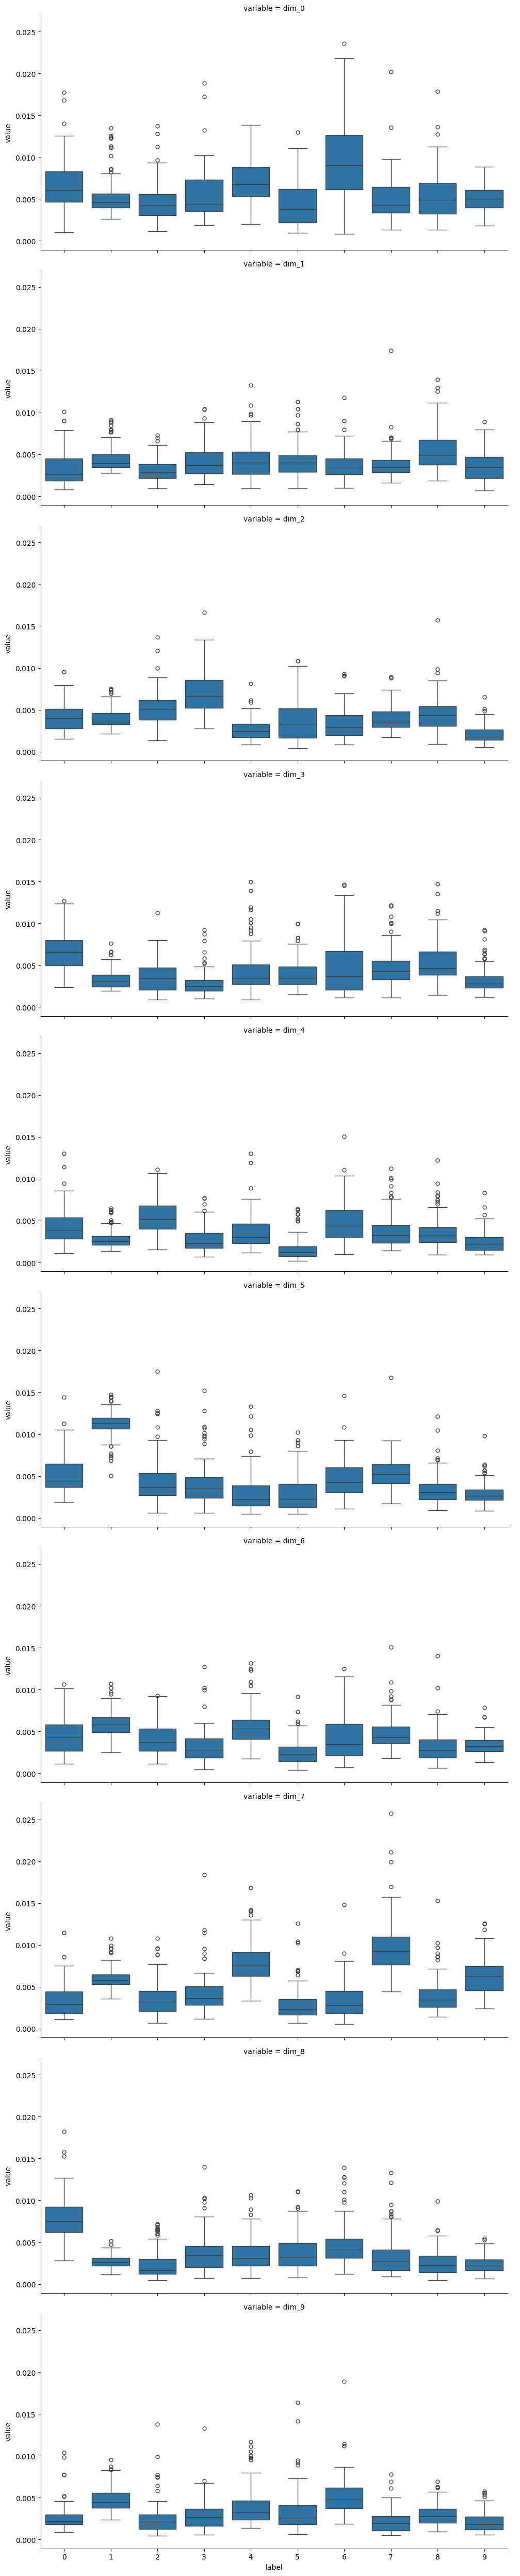

In [41]:
# visualize values of latent dims for each class

def plot_latent_box(z, y):
    latent_df = pd.DataFrame(z, columns=[f"dim_{i}" for i in range(10)])
    latent_df["label"] = y

    sns.catplot(latent_df.melt(id_vars="label"), row="variable", x="label", y="value", kind="box", aspect=2)

plot_latent_box(z_test, y_test)

# t-SNE of latent representations

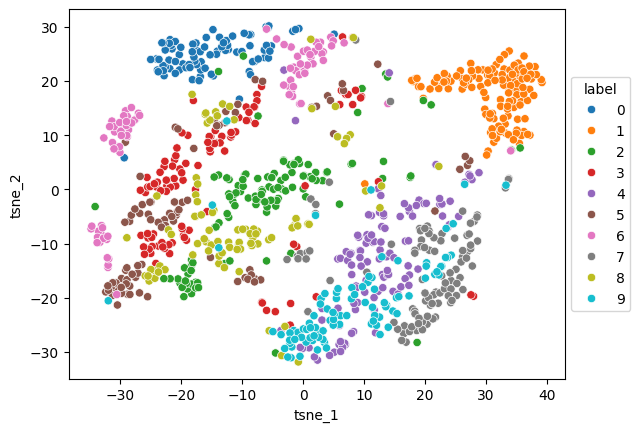

In [42]:
def plot_latent_tsne(z, y, random_state=19):
    latent_tsne = TSNE(random_state=random_state)

    z_tsne = latent_tsne.fit_transform(z)

    z_tsne_df = pd.DataFrame({
        "tsne_1": z_tsne[:, 0],
        "tsne_2": z_tsne[:, 1],
        "label": y.numpy().astype(str)
    })

    ax = sns.scatterplot(z_tsne_df.sort_values("label"), x="tsne_1", y="tsne_2", hue="label")
    sns.move_legend(ax, "center left", bbox_to_anchor=(1,0.5))

    return z_tsne

z_tsne = plot_latent_tsne(z_test, y_test)

## Meaningful latent representations with Semi-Supervised Learning

It would be really awesome, if our autoencoder would learn a one hot like latent representation of the images.
For example, if it would produce the vector $z = [0,1,0,0,0,0,0,0,0,0]$ for images that show a 1, etc.
However, even with L1 or entropy loss, we didn't quite get there.
So, let's use a little trick and splice in some supervised learning via a backdoor.
But instead of labelling the full dataset, we will label exactly one instance from each class.
Then, we will modify our training objective (the loss function), so that we encourage the labelled instances to receive the latent representation we would like them to have.
Hopefully, this will also end up shaping the latent representations of the unlabeled instances the way we want them to look like.

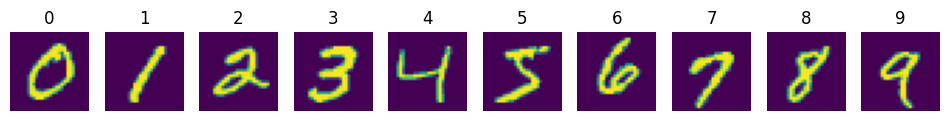

In [43]:
# extract class prototypes

n_train = 1000
x_train = torch.stack([train_ds[i][0] for i in range(n_train)])
y_train = torch.tensor([train_ds[i][1] for i in range(n_train)])

prototypes = {i: (x_train[y_train == i])[0] for i in range(10)}
x_proto = torch.stack([v for v in prototypes.values()])
y_proto = torch.tensor([k for k in prototypes.keys()])

plt.figure(figsize=(12,4))

for i, (y, x) in enumerate(prototypes.items()):
    plt.subplot(1, 10, i+1)
    plt.imshow(x.squeeze())
    plt.axis(False)
    plt.title(i)

plt.show()


In [ ]:
def train_semisupervised(model, train_dl, n_epochs, x_proto, y_proto, lambda_proto = 1, log_interval=100, device="cpu"):
    """Train an autoencoder to reproduce the input, while encouraging latent representations to classify prototypes."""
    model.to(device)
    model.train()
    criterion_reco = nn.MSELoss()
    loss_log = []
    optimizer = Adam(model.parameters(), lr=1e-4)
    criterion_proto = nn.NLLLoss()

    step = 0
    for epoch in trange(n_epochs):
        for x, _ in train_dl:
            # reconstruction loss
            x_hat, _ = model(x)
            loss_reco = criterion_reco(x_hat, x)

            # encode labelled prototypes and apply classification loss
            _, z_proto = model(x_proto)
            loss_proto = criterion_proto(torch.log(z_proto), y_proto)

            loss = loss_reco + lambda_proto * loss_proto

            if step % log_interval == 0:
                loss_log.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step += 1
    
    return loss_log

In [26]:
model_proto = AutoEncoder(n_latent=10, encoder_kwargs={"activation": "softmax"})

loss_log_proto = train_semisupervised(model_proto, train_dl, n_epochs=EPOCHS, x_proto=x_proto, y_proto=y_proto, lambda_proto=1)

100%|██████████| 5/5 [03:14<00:00, 38.96s/it]


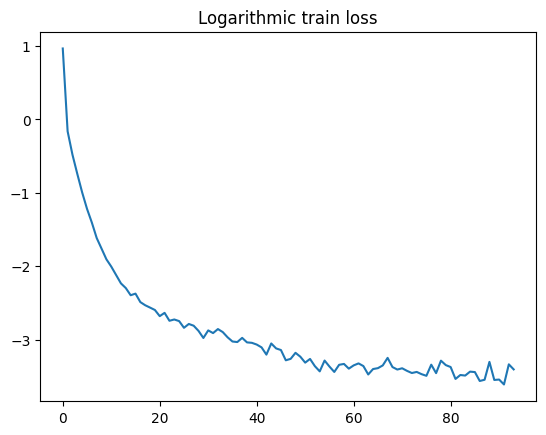

In [27]:
plot_loss(loss_log_proto)

In [35]:
# evaluate prototypes
model_proto.eval()

with torch.no_grad():
    _, z_proto = model_proto(x_proto)

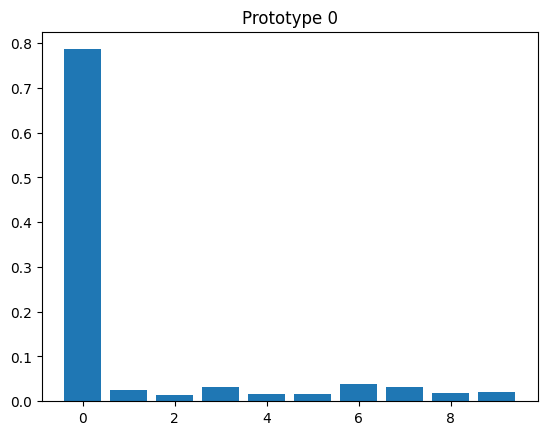

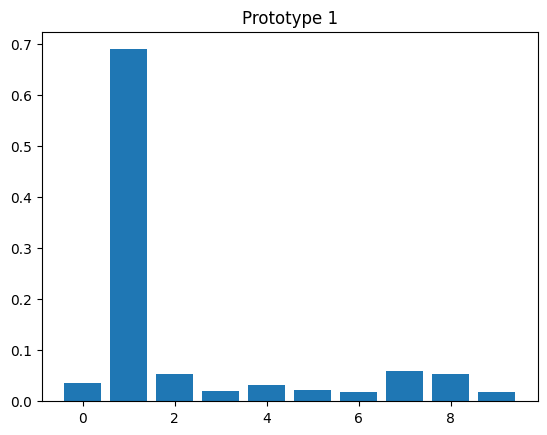

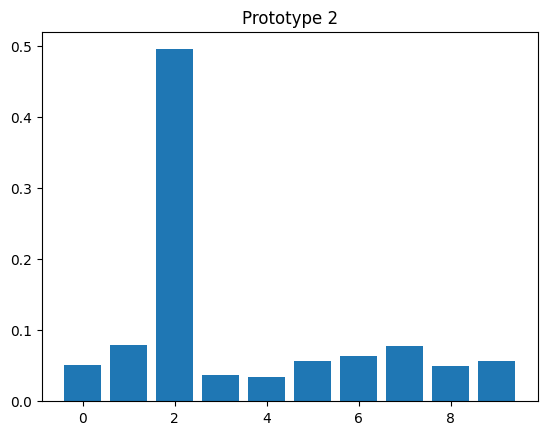

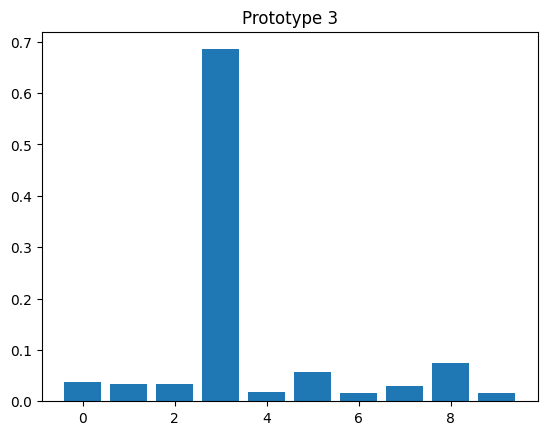

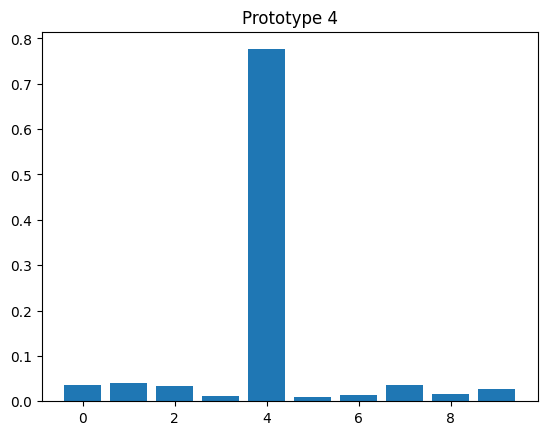

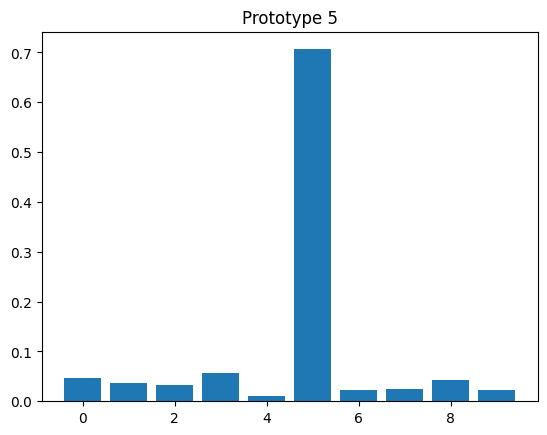

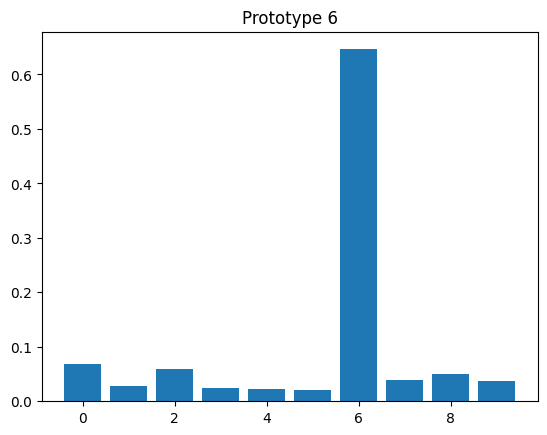

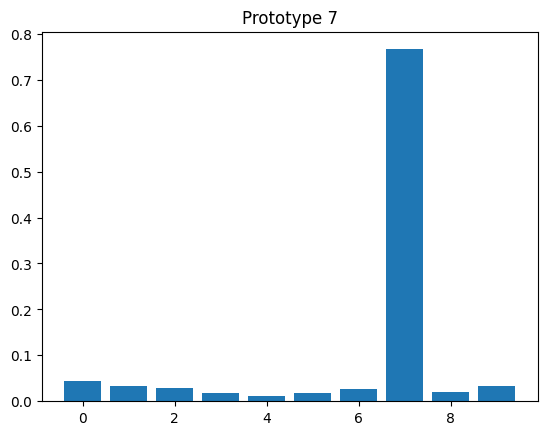

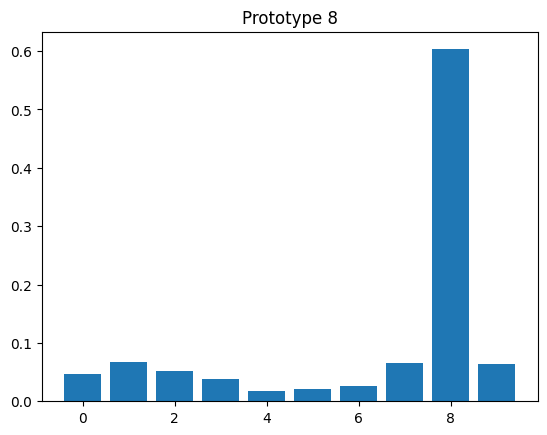

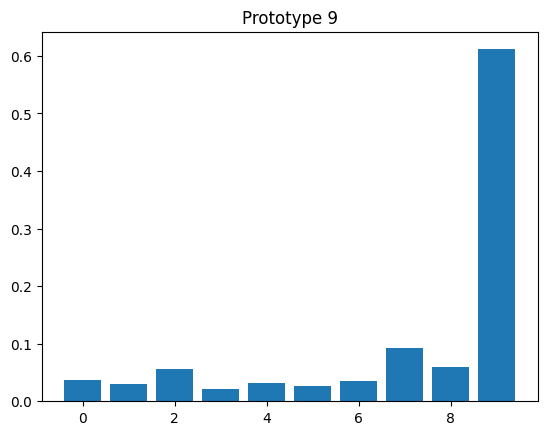

<Figure size 640x480 with 0 Axes>

In [36]:
for y, z in zip(y_proto, z_proto):
    plt.bar(np.arange(10), z)
    plt.title(f"Prototype {y.item()}")
    plt.figure()

In [34]:
# get test embeddings
n_test = 1_000

x_test = torch.stack([test_ds[i][0] for i in range(n_test)])
y_test = torch.tensor([test_ds[i][1] for i in range(n_test)])

In [40]:
with torch.no_grad():
    _, z_test = model_proto(x_test)

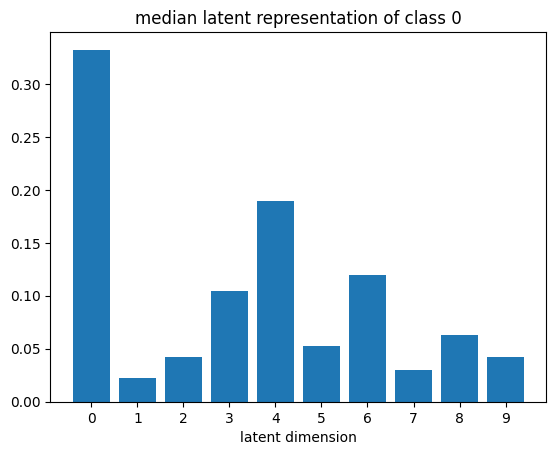

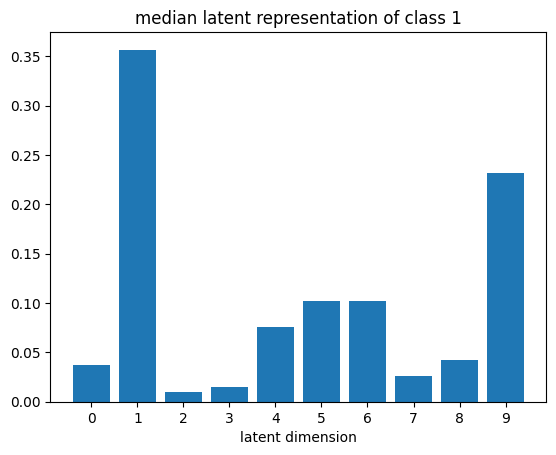

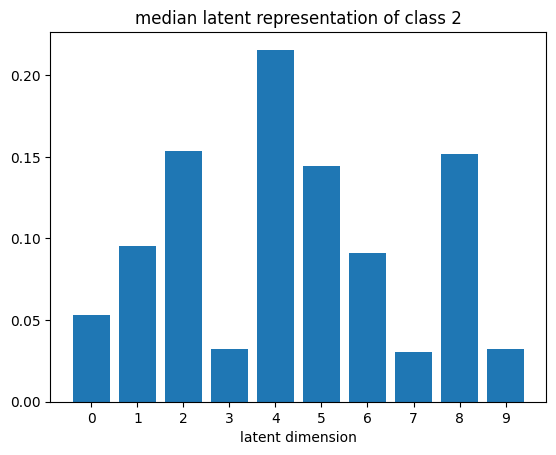

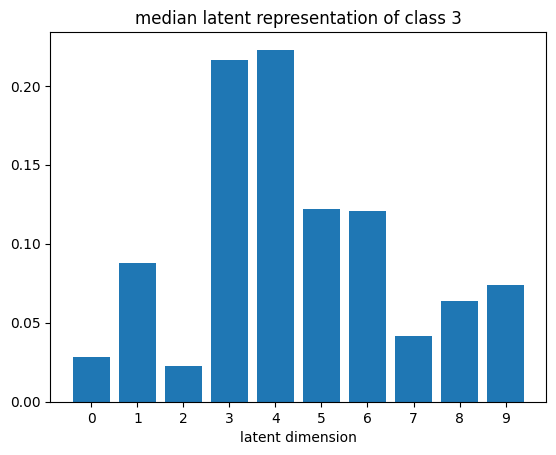

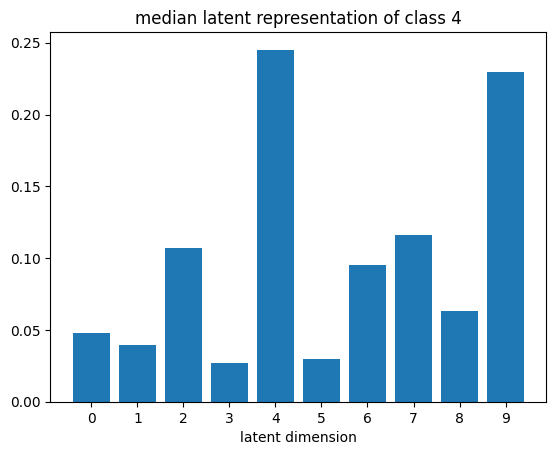

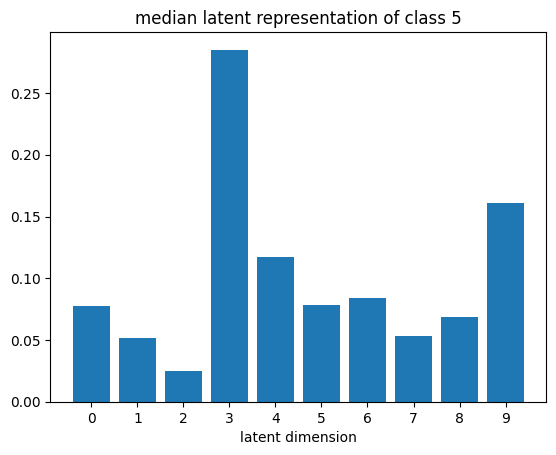

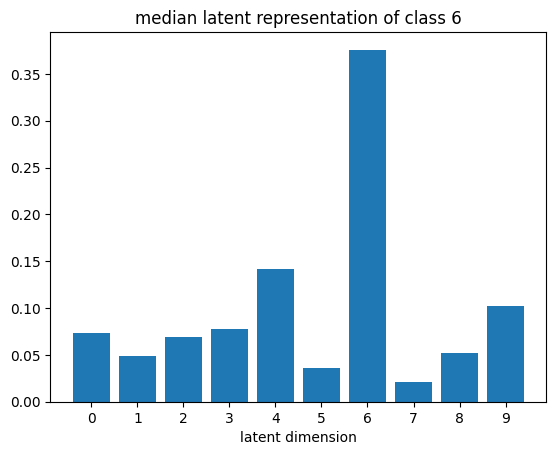

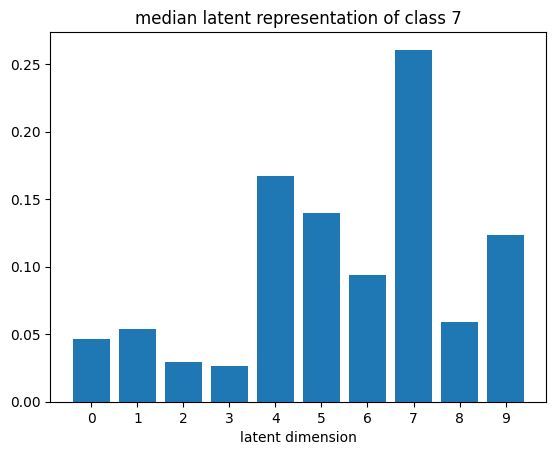

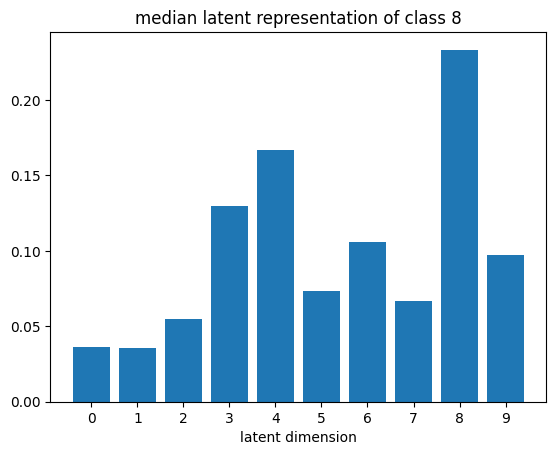

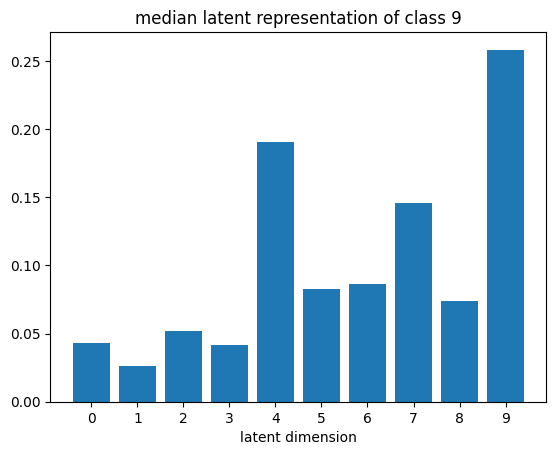

In [42]:
plot_latent_median(z_test, y_test)

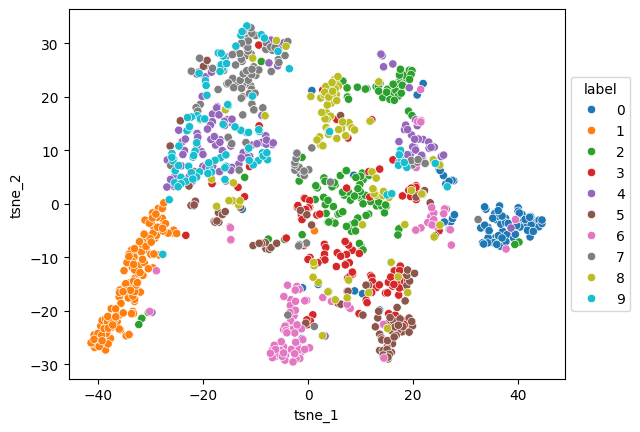

In [44]:
plot_latent_tsne(z_test, y_test);

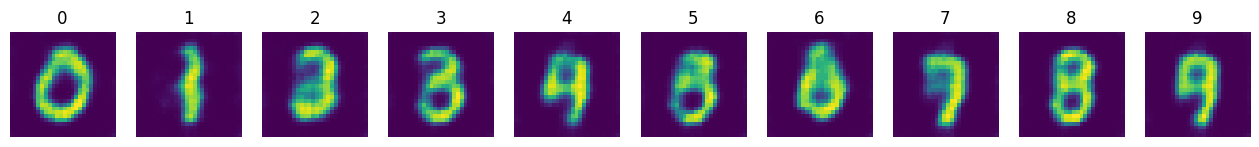

In [46]:
plot_mean_latent_reco(model_proto, z_test, y_test)

## Conclusion

In this tutorial, we created an Autoencoder for the popular MNIST dataset.
We saw that *interpreting the latent dimensions of an Autoencoder is challenging*.
Therefore, we tried to *encourage sparse representations* by adding an additional $L_1$ penalty, or by adding a supervised classification loss for a small subset of labelled "prototype" instances.
While this worked to some degree, there is *still no guarantee that the latent representation is actually meaningful*.
Next, we will take a look at Variational Autoencoders (VAEs), which consider the latent representation to be a latent probabilistic variable that can be inferred from observations.